In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2048000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                32768016  
Total params: 32,768,784
Trainable params: 32,768,784
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1777, 128)         82048     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 592, 128)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2785 - acc: 0.2432
Epoch 00001: val_loss improved from inf to 1.59926, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_6_conv_checkpoint/001-1.5993.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 2.2784 - acc: 0.2432 - val_loss: 1.5993 - val_acc: 0.4959
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5779 - acc: 0.4813
Epoch 00002: val_loss improved from 1.59926 to 1.35839, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_6_conv_checkpoint/002-1.3584.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.5780 - acc: 0.4813 - val_loss: 1.3584 - val_acc: 0.5604
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3288 - acc: 0.5713
Epoch 00003: val_loss improved from 1.35839 to 1.06009, saving 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3522 - acc: 0.8924
Epoch 00024: val_loss did not improve from 0.37986
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3523 - acc: 0.8924 - val_loss: 0.3858 - val_acc: 0.8970
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8964
Epoch 00025: val_loss did not improve from 0.37986
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3366 - acc: 0.8963 - val_loss: 0.4099 - val_acc: 0.8919
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3305 - acc: 0.8999
Epoch 00026: val_loss did not improve from 0.37986
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3306 - acc: 0.8999 - val_loss: 0.3945 - val_acc: 0.8940
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3212 - acc: 0.9015
Epoch 00027: val_loss did not improve from 0.37986
36805/36805 [========

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1740 - acc: 0.9434
Epoch 00052: val_loss did not improve from 0.34439
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1740 - acc: 0.9434 - val_loss: 0.3760 - val_acc: 0.9124
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1694 - acc: 0.9447
Epoch 00053: val_loss did not improve from 0.34439
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1694 - acc: 0.9447 - val_loss: 0.3847 - val_acc: 0.9138
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1689 - acc: 0.9441
Epoch 00054: val_loss improved from 0.34439 to 0.33623, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_6_conv_checkpoint/054-0.3362.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1689 - acc: 0.9441 - val_loss: 0.3362 - val_acc: 0.9199
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9610
Epoch 00081: val_loss did not improve from 0.33623
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1161 - acc: 0.9610 - val_loss: 0.3771 - val_acc: 0.9194
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1140 - acc: 0.9614
Epoch 00082: val_loss did not improve from 0.33623
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1140 - acc: 0.9614 - val_loss: 0.3635 - val_acc: 0.9231
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9644
Epoch 00083: val_loss did not improve from 0.33623
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1058 - acc: 0.9644 - val_loss: 0.3624 - val_acc: 0.9189
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9655
Epoch 00084: val_loss did not improve from 0.33623
36805/36805 [=====================

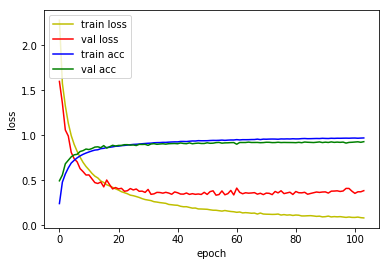

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3915 - acc: 0.8995
Loss: 0.3914603922164081 Accuracy: 0.89948076

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3805 - acc: 0.2178
Epoch 00001: val_loss improved from inf to 1.65214, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_7_conv_checkpoint/001-1.6521.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 2.3805 - acc: 0.2178 - val_loss: 1.6521 - val_acc: 0.4540
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6757 - acc: 0.4422
Epoch 00002: val_loss improved from 1.65214 to 1.36536, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_7_conv_checkpoint/002-1.3654.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.6757 - acc: 0.4422 - val_loss: 1.3654 - val_acc: 0.5642
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3239 - acc: 0.8990
Epoch 00023: val_loss improved from 0.27053 to 0.25465, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_7_conv_checkpoint/023-0.2546.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.3239 - acc: 0.8990 - val_loss: 0.2546 - val_acc: 0.9338
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3135 - acc: 0.9033
Epoch 00024: val_loss did not improve from 0.25465
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.3134 - acc: 0.9034 - val_loss: 0.2779 - val_acc: 0.9175
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3045 - acc: 0.9065
Epoch 00025: val_loss improved from 0.25465 to 0.24859, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_7_conv_checkpoint/025-0.2486.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.3045 - acc: 0.9066 - val_loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9452
Epoch 00049: val_loss did not improve from 0.18462
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1716 - acc: 0.9452 - val_loss: 0.2115 - val_acc: 0.9467
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9420
Epoch 00050: val_loss did not improve from 0.18462
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1779 - acc: 0.9420 - val_loss: 0.1962 - val_acc: 0.9518
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1715 - acc: 0.9443
Epoch 00051: val_loss did not improve from 0.18462
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1715 - acc: 0.9443 - val_loss: 0.1949 - val_acc: 0.9478
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1710 - acc: 0.9446
Epoch 00052: val_loss did not improve from 0.18462
36805/36805 [=====================

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9601
Epoch 00077: val_loss did not improve from 0.17233
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1160 - acc: 0.9601 - val_loss: 0.1891 - val_acc: 0.9527
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9621
Epoch 00078: val_loss did not improve from 0.17233
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1146 - acc: 0.9620 - val_loss: 0.1959 - val_acc: 0.9513
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1141 - acc: 0.9610
Epoch 00079: val_loss did not improve from 0.17233
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1141 - acc: 0.9610 - val_loss: 0.1777 - val_acc: 0.9529
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9631
Epoch 00080: val_loss did not improve from 0.17233
36805/36805 [========

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9707
Epoch 00107: val_loss did not improve from 0.17233
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0854 - acc: 0.9707 - val_loss: 0.2055 - val_acc: 0.9562
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9712
Epoch 00108: val_loss did not improve from 0.17233
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.0837 - acc: 0.9712 - val_loss: 0.1977 - val_acc: 0.9518
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9721
Epoch 00109: val_loss did not improve from 0.17233
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0817 - acc: 0.9721 - val_loss: 0.1909 - val_acc: 0.9553
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9741
Epoch 00110: val_loss did not improve from 0.17233
36805/36805 [====

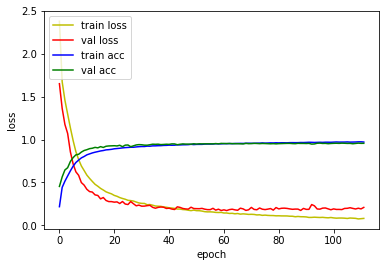

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2034 - acc: 0.9421
Loss: 0.20344936875539404 Accuracy: 0.94205606

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4123 - acc: 0.2112
Epoch 00001: val_loss improved from inf to 1.77737, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_8_conv_checkpoint/001-1.7774.hdf5
36805/36805 [==============================] - 116s 3ms/sample - loss: 2.4122 - acc: 0.2112 - val_loss: 1.7774 - val_acc: 0.4458
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6858 - acc: 0.4477
Epoch 00002: val_loss improved from 1.77737 to 1.18714, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_8_conv_checkpoint/002-1.1871.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.6856 - acc: 0.4478 - val_loss: 1.1871 - val_acc: 0.6385
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2681 - acc: 0.9152
Epoch 00023: val_loss did not improve from 0.17794
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.2680 - acc: 0.9152 - val_loss: 0.1952 - val_acc: 0.9425
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2622 - acc: 0.9168
Epoch 00024: val_loss did not improve from 0.17794
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.2622 - acc: 0.9168 - val_loss: 0.1813 - val_acc: 0.9457
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2570 - acc: 0.9176
Epoch 00025: val_loss did not improve from 0.17794
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.2570 - acc: 0.9176 - val_loss: 0.1782 - val_acc: 0.9485
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9210
Epoch 00026: val_loss did not improve from 0.17794
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9546
Epoch 00050: val_loss did not improve from 0.12881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1383 - acc: 0.9547 - val_loss: 0.1420 - val_acc: 0.9560
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9553
Epoch 00051: val_loss did not improve from 0.12881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1356 - acc: 0.9553 - val_loss: 0.1289 - val_acc: 0.9637
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9566
Epoch 00052: val_loss did not improve from 0.12881
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1311 - acc: 0.9566 - val_loss: 0.1361 - val_acc: 0.9639
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1252 - acc: 0.9585
Epoch 00053: val_loss did not improve from 0.12881
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9714
Epoch 00078: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0828 - acc: 0.9714 - val_loss: 0.1426 - val_acc: 0.9604
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0856 - acc: 0.9708
Epoch 00079: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0856 - acc: 0.9708 - val_loss: 0.1341 - val_acc: 0.9681
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9730
Epoch 00080: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0777 - acc: 0.9730 - val_loss: 0.1271 - val_acc: 0.9660
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9710
Epoch 00081: val_loss did not improve from 0.12135
36805/36805 [=====================

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9799
Epoch 00108: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0567 - acc: 0.9799 - val_loss: 0.1538 - val_acc: 0.9674
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9820
Epoch 00109: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0539 - acc: 0.9820 - val_loss: 0.1347 - val_acc: 0.9669
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9800
Epoch 00110: val_loss did not improve from 0.12135
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0560 - acc: 0.9800 - val_loss: 0.1460 - val_acc: 0.9641
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9815
Epoch 00111: val_loss did not improve from 0.12135
36805/36805 [====

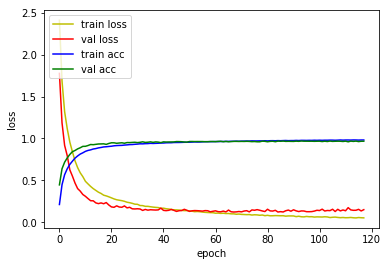

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1828 - acc: 0.9516
Loss: 0.18280254292958498 Accuracy: 0.95160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3524 - acc: 0.2341
Epoch 00001: val_loss improved from inf to 1.55710, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_9_conv_checkpoint/001-1.5571.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 2.3522 - acc: 0.2342 - val_loss: 1.5571 - val_acc: 0.5593
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6548 - acc: 0.4717
Epoch 00002: val_loss improved from 1.55710 to 1.07656, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_9_conv_checkpoint/002-1.0766.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.6546 - acc: 0.4718 - val_loss: 1.0766 - val_acc: 0.6851
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.3425 - acc: 0.8940
Epoch 00023: val_loss improved from 0.19096 to 0.18345, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_9_conv_checkpoint/023-0.1834.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.3425 - acc: 0.8940 - val_loss: 0.1834 - val_acc: 0.9488
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3355 - acc: 0.8962
Epoch 00024: val_loss did not improve from 0.18345
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.3355 - acc: 0.8962 - val_loss: 0.1912 - val_acc: 0.9488
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3227 - acc: 0.9008
Epoch 00025: val_loss did not improve from 0.18345
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.3227 - acc: 0.9009 - val_loss: 0.1951 - val_acc: 0.9450
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3065 -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1716 - acc: 0.9441
Epoch 00050: val_loss did not improve from 0.13711
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1716 - acc: 0.9441 - val_loss: 0.1495 - val_acc: 0.9609
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1673 - acc: 0.9477
Epoch 00051: val_loss did not improve from 0.13711
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.1672 - acc: 0.9477 - val_loss: 0.1601 - val_acc: 0.9632
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1659 - acc: 0.9460
Epoch 00052: val_loss did not improve from 0.13711
36805/36805 [==============================] - 114s 3ms/sample - loss: 0.1659 - acc: 0.9460 - val_loss: 0.1529 - val_acc: 0.9611
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1611 - acc: 0.9474
Epoch 00053: val_loss did not improve from 0.13711
36805/36805 [========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9668
Epoch 00080: val_loss did not improve from 0.13711
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0989 - acc: 0.9668 - val_loss: 0.1746 - val_acc: 0.9618
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9674
Epoch 00081: val_loss did not improve from 0.13711
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0967 - acc: 0.9674 - val_loss: 0.1578 - val_acc: 0.9679
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9677
Epoch 00082: val_loss did not improve from 0.13711
36805/36805 [==============================] - 113s 3ms/sample - loss: 0.0945 - acc: 0.9677 - val_loss: 0.1568 - val_acc: 0.9646
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9683
Epoch 00083: val_loss did not improve from 0.13711
36805/36805 [========

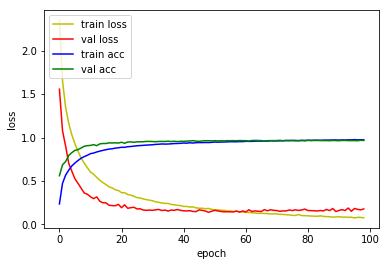

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1970 - acc: 0.9425
Loss: 0.19702063239530612 Accuracy: 0.94247144



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         82048     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1970 - acc: 0.9425
Loss: 0.19702063239530612 Accuracy: 0.94247144


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 128)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         82048     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2195 - acc: 0.9504
Loss: 0.21948599532180826 Accuracy: 0.95036346
